In [773]:
using Images
using ImageTransformations
using Interpolations
using LinearAlgebra
using Random, Distributions, StatsBase, Plots
rngSeed = Random.seed!(0)
dirFile = "/home/javiersc/Desktop/CroppedYale/yaleB28/"
f = open(string(dirFile,"yaleB28_P00.info"));
lines = readlines(f);
scaleFactor = 3
dataMatrix = zeros(round(Int,192*168/(scaleFactor^2)),length(lines))
i = 1
for l in lines
        img = load(string(dirFile, l))
        img = convert(Array{Float64}, img)
        σ = map((o,n) -> 0.75*o/n, size(img), ceil.(Int, size(img).*(1/scaleFactor)) )
        kern = KernelFactors.gaussian(σ)
        #img = imresize(imfilter(img,kern,NA()), ratio=1/scaleFactor, method=BSpline(Linear()))
        img = imresize(img, ratio=1/scaleFactor, method=BSpline(Linear()))
        dataMatrix[:,i] = vec(img)
        i += 1
end
D, N = size(dataMatrix)
permutationOrder = randperm(Random.seed!(0), N)
dataMatrix = dataMatrix[:,permutationOrder]
sampleMean = mean(dataMatrix,dims=2)
dataMatrix = dataMatrix .- sampleMean
 # David's SignFlip PA
σfs = [svdvals(rand([-1,1],size(dataMatrix)) .* dataMatrix) for _ in 1:5]
σfs = [getindex.(σfs,j) for j in 1:min(D,N)]
α = 0.95
rank = findfirst(svdvals(dataMatrix) .<= quantile.(σfs,α)) - 1
U = svd(dataMatrix).U[:,1:rank];
projectedMatrix = U*U'*dataMatrix;

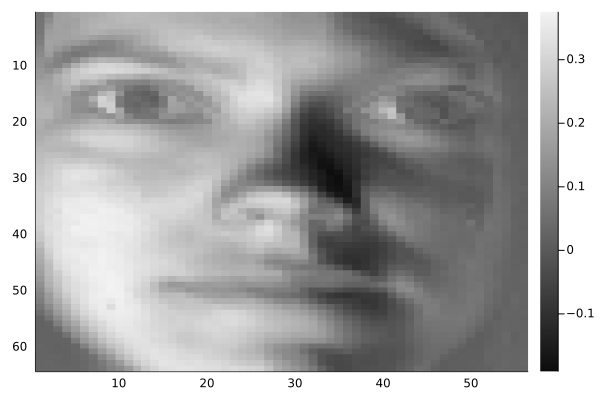

In [774]:
img = reshape(projectedMatrix[:,45],(round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
heatmap(img, yflip=true, c=:grays)
#savefig("FACES_EXAMPLE_IMAGE.pdf")

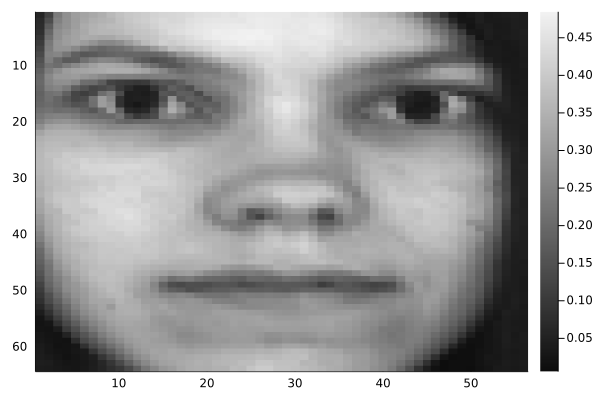

In [715]:
heatmap(reshape(sampleMean,(round(Int,192/scaleFactor),round(Int,168/scaleFactor))), yflip=true, c=:grays)

In [775]:
using MAT
file = matopen("/home/javiersc/Desktop/heavyBlur.mat")
heavyBlur = read(file, "newMatrixHeavy") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

file = matopen("/home/javiersc/Desktop/lightBlur.mat")
lightBlur = read(file, "newMatrixLight") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

In [776]:
#b1 = heavyBlur*sampleMean - sampleMean
#b2 = lightBlur*sampleMean - sampleMean

goodSamples = 4

function op(dataMatrix)
    #output1 = lightBlur*dataMatrix #.+ b2
    output1 = heavyBlur*dataMatrix[:,(goodSamples+1):end] #.+ b1
    output2 = lightBlur*dataMatrix[:,1:goodSamples] #.+ b2
    output = hcat(output2,output1)
    return output
end

function op_same(dataMatrix)
    output = heavyBlur*dataMatrix
    return output 
end

function adjoint_op_same(dataMatrix)
    output = heavyBlur'*dataMatrix
    return output 
end

function adjoint_op(dataMatrix)
    #output1 = lightBlur'*dataMatrix 
    output1 = heavyBlur'*dataMatrix[:,(goodSamples+1):end] #.+ b1
    output2 = lightBlur'*dataMatrix[:,1:goodSamples] #.+ b2
    output = hcat(output2,output1)
    return output
end

function generateData(dataMatrix)
    rngSeed = Random.seed!(0)
    output1 = heavyBlur*dataMatrix[:,(goodSamples+1):end] #.+ b1
    output2 = lightBlur*dataMatrix[:,1:goodSamples] #.+ b2
    #output1 = output1 + rand(Normal(0,0.01), size(output1))
    #output2 = output2 + rand(Normal(0,0.01), size(output2))
    output = hcat(output2,output1)
    output = output + rand(Normal(0,0.01), size(output))
    return output
end

# function adjoint_op(dataMatrix)
#     output1 = heavyBlur'*dataMatrix[:,(goodSamples+1):end]
#     output2 = lightBlur'*dataMatrix[:,1:goodSamples]
#     return hcat(output2,output1)
# end

generateData (generic function with 1 method)

In [777]:
#Π = 1/22 * diag((generateData(dataMatrix)-op(dataMatrix))'*(generateData(dataMatrix)-op(dataMatrix)))
Π = 1/22 * diag((generateData(dataMatrix)-dataMatrix)'*(generateData(dataMatrix)-dataMatrix))
Π_known = zeros(size(Π))
Π_known[1:goodSamples] .= mean(Π[1:goodSamples])
Π_known[(goodSamples+1):end] .= mean(Π[(goodSamples+1):end]);
Π_known

64-element Vector{Float64}:
 0.3124200959221619
 0.3124200959221619
 0.3124200959221619
 0.3124200959221619
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 ⋮
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916
 0.9948968580126916

In [738]:
size(dataMatrix)

(3584, 64)

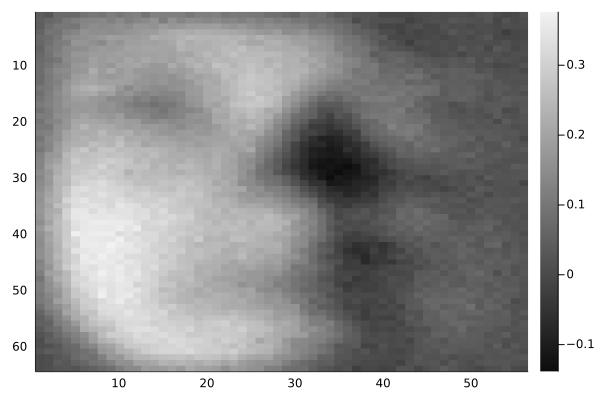

In [778]:
test = generateData(projectedMatrix);
imgTest = reshape(test[:,45] ,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;
heatmap(imgTest, yflip=true, c=:grays)
#savefig("FACES_HIGH_BLURRY.pdf")

In [779]:
# Y_same = op_same(projectedMatrix[:,1:goodSamples])
Y = generateData(projectedMatrix)
# Π = diag((1/D)*(Y-projectedMatrix)'*(Y-projectedMatrix))
# Π_known = zeros(size(Π))
# Π_known[1:goodSamples] .= mean(Π[1:goodSamples])
# Π_known[(goodSamples+1):N] .= mean(Π[(goodSamples+1):N]);
# Π_known

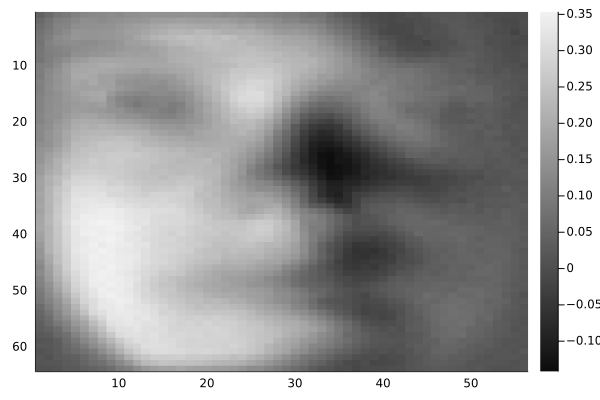

In [732]:
U_test = svd(Y[:,1:goodSamples]).U[:,1:4];
denoised = U_test*U_test'*Y
denoisedTest = reshape(denoised[:,45] ,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;
heatmap(denoisedTest, yflip=true, c=:grays)

In [723]:
U_PPCA = svd(Y).U[:,1:rank]
error_pca = norm(U_PPCA*U_PPCA' - U*U', 2)/norm(U*U',2)

0.3932459528666786

In [741]:
include("pogm_restart.jl")
function HPCA_POGM(Y, λr,w, N, bound)
    Π = Diagonal(w.^-1)
    Lf = 1*opnorm(Array(heavyBlur),2)^2 #max((opnorm(Array(lightBlur),2)), (opnorm(Array(heavyBlur),2)))^2
    x0 = zeros(size(Y)) #deepcopy(Y) #zeros(size(Y))
    grad = K -> -1*adjoint_op_same((Y-op_same(K)))
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*Diagonal(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    T, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=bound, mom=:fpgm, restart=:gr) #pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=bound, mom=:fpgm, restart=:gr)
    #U = svd(T).U[:,1:3]
    return T
end

function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    return max.(Π, 1e-9)
end

function W_ALL_GROUPS(Y, L)
    Π = vec(zeros(size(Y)[2],1))
    d = size(Y)[1]
    N = size(Y)[2]
    Π[1:goodSamples] .= (1/(d*goodSamples))*norm(Y[:,1:goodSamples]-L[:,1:goodSamples],2)^2
    Π[(goodSamples+1):end] .= (1/(d*(N-goodSamples)))*norm(Y[:,(goodSamples+1):end]-L[:,(goodSamples+1):end],2)^2
    return max.(Π, 1e-9)
end

function HPCA_APGD(Y, λr, w, N, ϵ, X0)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    K, _ = pogm_restart(X0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ, mom=:fpgm, restart=:gr) # objective(x,Y-x,λr,w)
    return K
end
function AltMin(Y, λr, N, ϵ)
    Π = ones(size(Y)[2])
    X = zeros(size(Y)) .+ 1
    X0 = zeros(size(Y)) .+ 1e-6
    while norm(X-X0, 2)/norm(X0,2) > 1e-6
        X0 = X
        X = HPCA_APGD(Y, λr, Π, N, ϵ, X)
        Π = W_ALL_GROUPS(Y, X)
    end
    return X, Π
end

AltMin (generic function with 1 method)

In [233]:
X_HPCA, VTEST = AltMin(Y, 10000, 0, 1e-3);

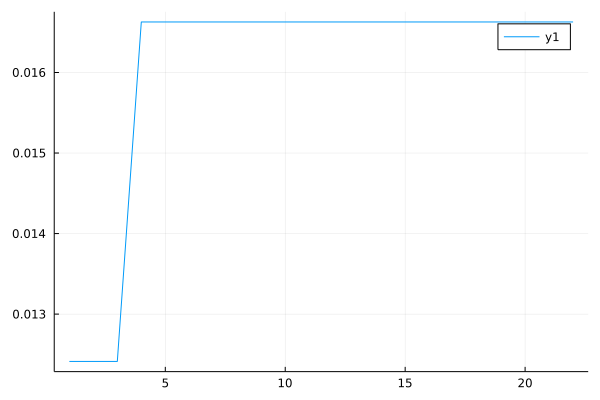

In [234]:
plot(VTEST)
#plot!(Π_known)

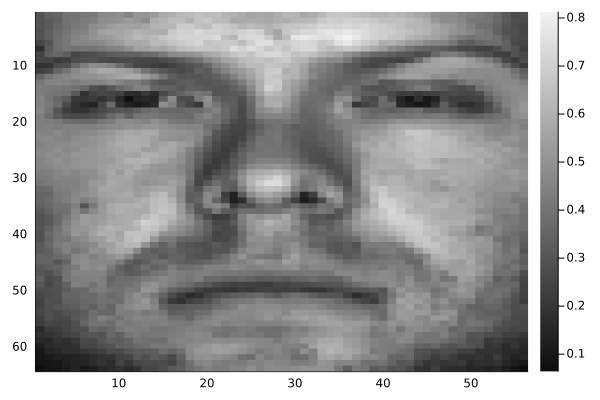

In [237]:
imgX_HPCA = X_HPCA[:,5]+sampleMean;
imgX_HPCA = reshape(imgX_HPCA,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;
heatmap(imgX_HPCA, yflip=true, c=:grays)
#savefig("FACES_RECONSTRUCTED.pdf")

In [791]:
Π_test = vcat(1*ones(goodSamples), 10*ones(size(Y)[2]-goodSamples));
Π_naive = ones(size(Y)[2]);
X_HPCA = HPCA_POGM(Y, 0.2, Π_test, 0, 1e-2);
imgX_HPCA = X_HPCA[:,45] .+ sampleMean;
imgX_HPCA = reshape(imgX_HPCA,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;

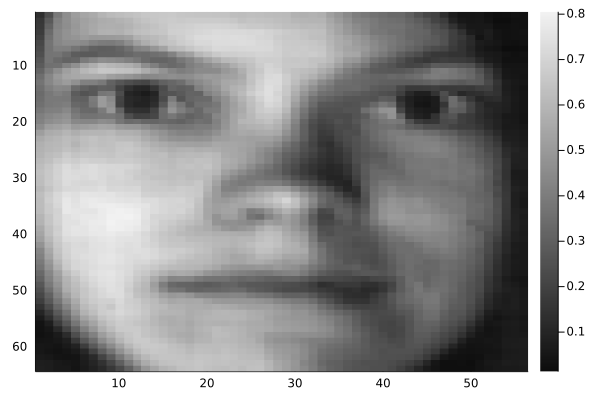

In [792]:
heatmap(imgX_HPCA, yflip=true, c=:grays)
#savefig("FACES_RECONSTRUCTED.pdf")

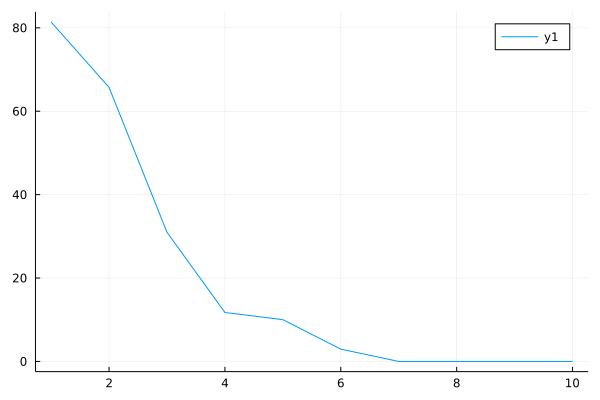

In [789]:
plot(svd(X_HPCA).S[1:10])

In [790]:
using ImageQualityIndexes
assess_psnr(imgX_HPCA, img)

34.84459098345414

In [785]:
assess_psnr(imgTest, img)

27.221893278043122

In [786]:
assess_psnr(denoisedTest, img)

28.10385710676256